# Setup
## Constants

In [1]:
# False if you have already created and saved a .pth file to PTH_SAVE_PATH
CREATE_NEW_DATASET = True

# train, test, val set size. Should sum to 1
SET_SIZES = {
    "train": 0.8,
    "test": 0.1,
    "val": 0.1,
}

# samples per class in uniform dataset
N_SAMPLES = 400

# path to dataset (do not change)
HM_DATA_PATH = "../dataset/"

# path to pth saves (do not change)
PTH_SAVE_PATH = "../pth/"

## Imports

In [2]:
import os, sys, random, gdown, importlib, transformers, itertools, copy
import numpy as np, torch.nn as nn, torch, seaborn as sns, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
print(os.getcwd())# Our own files
# sys.path.append('./src/')
import model_functions, utils, training, datasets
def set_seed(seed):# reproducable
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(0)

/home/jupyter/DD2430_Project/src


In [52]:
def update():# if you change our files
    import model_functions, utils, training, datasets
    for lib in [model_functions, utils, training, datasets]:
        importlib.reload(lib)# issues with not updating
update()

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available(): # For apple silicon
    device = 'mps'
print("Using device:", device)

Using device: cuda


## Download data
Only run this once.

In [5]:
if not os.path.exists(HM_DATA_PATH): # big folder data
    gdown.download("https://drive.google.com/uc?id=1EZ3AfRp-RMj70qZzIAC-BR0sHsrfjOWx")
    !unzip -q dataset.zip -d ../
    !rm -fr dataset.zip
else:
    print("Data already downloaded.")

Data already downloaded.


In [6]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

/opt/conda/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


# Dataset

## Create new dataset
This will create a new dataset and save it as a .pth to google drive. If you getan error, then it is most likely becuase you can not make a daatset that large.

In [66]:
n_samples = 520
main_class = 'garment_group_name'
#subclasses = ['Unknown', 'Special Offers', 'some other', 'Woven/Jersey/Knitted mix Baby']#exclude
#subclasses = ['Shirts', 'Shoes', 'Socks and Tights', 'Accessories']#include
subclasses = ['Jersey Fancy', 'Jersey Basic', 'Swimwear', 'Shorts']
include = False # False if only the given classes

In [67]:
if CREATE_NEW_DATASET:
    hm_dataset = datasets.create_dataset(n_samples, main_class, subclasses, 
                   {'m':model, 'p':processor}, {'hm':HM_DATA_PATH, 'save':PTH_SAVE_PATH}, device, False, include)
    #print(hm_dataset.main_classes) all main classes

Max uniform size: 908


/opt/conda/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Counter({'Jersey Basic': 520, 'Jersey Fancy': 520, 'Swimwear': 520, 'Shorts': 520})


## Load dataset and split

In [68]:
batch_size = 2**8
print(batch_size)
data = datasets.load_dataset(n_samples, 'garment_group_name', len(subclasses),
                             {'hm':HM_DATA_PATH, 'save':PTH_SAVE_PATH})

dataloaders_tr_va_te = datasets.generate_train_test_val(data['class_text'], data['image_embedding'], data['images'],
                                               batch_size, n_samples, SET_SIZES)

256
2080 1664 208 208
Counter({'Jersey Basic': 520, 'Jersey Fancy': 520, 'Shorts': 520, 'Swimwear': 520})
Counter({'Swimwear': 416, 'Shorts': 416, 'Jersey Basic': 416, 'Jersey Fancy': 416})
Counter({'Swimwear': 52, 'Jersey Fancy': 52, 'Jersey Basic': 52, 'Shorts': 52})
Counter({'Swimwear': 52, 'Jersey Basic': 52, 'Shorts': 52, 'Jersey Fancy': 52})


# Evaluate

## Baseline

The performance of the untuned CLIP

100%|██████████| 1/1 [00:00<00:00, 32.58it/s]


Accuracy 64.42308044433594


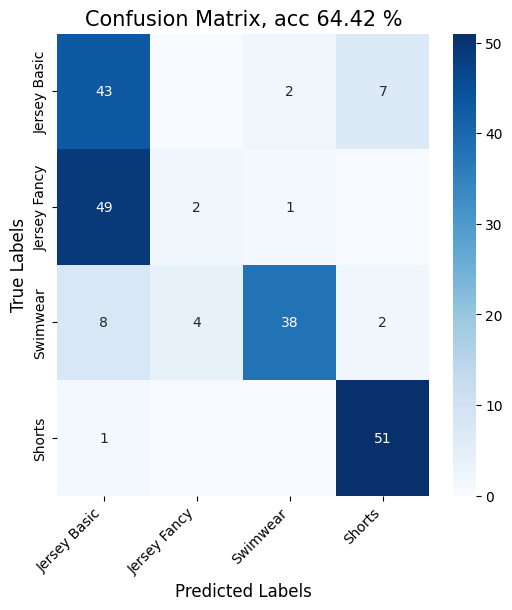

Accuracy of baseline is 64.42 %


In [69]:
def baseline(dataloaders, add):
    clip = {'m':model, 'p':processor}
    ft = training.FinetuneCLIP(dataloaders, clip)
    ft.tt['soft'], ft.tt['LoRA'] = 0, 0 #baseline
    ft.initialize({'add':add})
    all_predictions, all_labels, acc = ft.eval(False)
    utils.confussion_matrix(all_labels, all_predictions, list(dataloaders['test'].dataset.class_to_id.keys()),F1=False)
    return acc
    
acc = baseline({'train':dataloaders_tr_va_te['train'],
            'val':dataloaders_tr_va_te['val'],
            'test':dataloaders_tr_va_te['test']}, 
        add ='')
print(f"Accuracy of baseline is {acc:.2f} %")

## Hard prompt tuning

Easiest way to finetune, just change the text accompanied by labels

In [87]:
dataloaders = {'train':dataloaders_tr_va_te['train'], 'val':dataloaders_tr_va_te['val'], 'test':dataloaders_tr_va_te['test']}
clip = {'m':model, 'p':processor}

texts = ['', 'An image of', 'The cloathing type is', 'An image showing cloathing of type']
perf = []
for added_text in texts:
    ft = training.FinetuneCLIP(dataloaders, clip)
    ft.tt['soft'], ft.tt['LoRA'] = 0, 0 #baseline
    ft.train_p['add'] = added_text
    _, _, acc = ft.eval(False)
    perf.append(np.round(acc,2))
print(perf)
print(f"Best accuracy of hard-prompt tune is {max(perf):.2f} %")

100%|██████████| 1/1 [00:00<00:00, 33.31it/s]


Accuracy 84.0


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


Accuracy 91.5


100%|██████████| 1/1 [00:00<00:00, 35.78it/s]


Accuracy 90.5


100%|██████████| 1/1 [00:00<00:00, 50.44it/s]

Accuracy 92.5
[84.0, 91.5, 90.5, 92.5]
Best accuracy of hard-prompt tune is 92.50 %


## Soft prompt

Add a tunable tensor in the embedding of the text. Added hyperparam search

In [70]:
dataloaders = {'train':dataloaders_tr_va_te['train'], 'val':dataloaders_tr_va_te['val'], 'test':dataloaders_tr_va_te['test']}
clip = {'m':model, 'p':processor}
#[1,2,3,4,5,6]
hp ={'hyperp':[5], 'best_losses':[], 'params':[]}
for num_soft in hp['hyperp']:
    ft = training.FinetuneCLIP(dataloaders, clip, 300)
    ft.es['pat']=40
    ft.initialize({'num_soft':num_soft, 'add':''})
    ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc']  = 1, 0,0 #soft
    _, train_p = ft.train()
    hp['params'].append(train_p['soft']) # TODO load best of these later to evaluate on test set, I did not, i ran it again for [5].
    hp['best_losses'].append(ft.loss['val'][-ft.es['pat']])

Training: 100%|██████████| 300/300 [07:19<00:00,  1.46s/epoch, Patience=0 / 40]


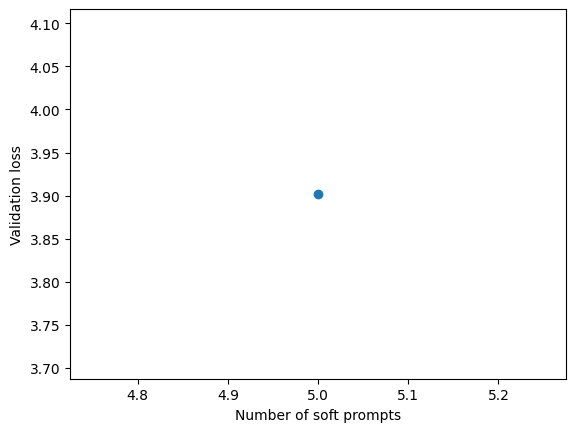

In [27]:
plt.plot(hp['hyperp'], hp['best_losses'], marker='o', linestyle='-')
plt.xlabel('Number of soft prompts')
plt.ylabel('Validation loss')
plt.show()

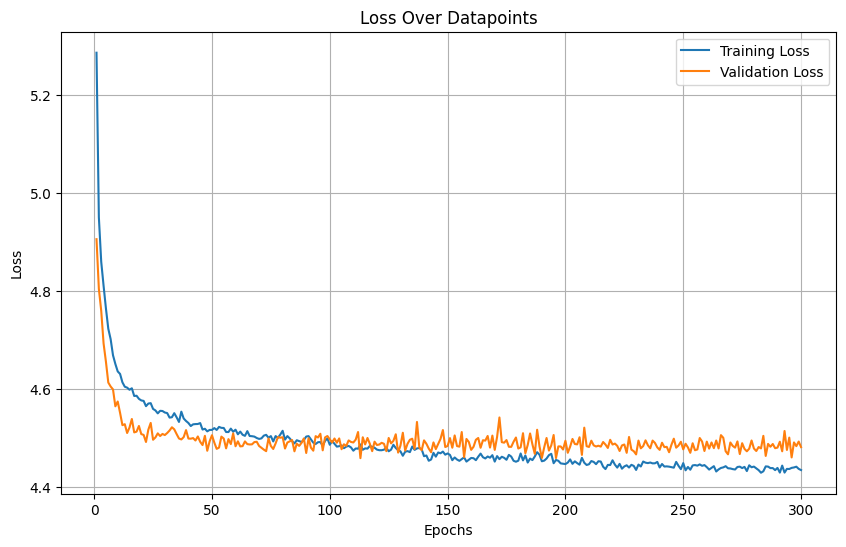

100%|██████████| 1/1 [00:00<00:00, 45.06it/s]


Accuracy 87.01923370361328


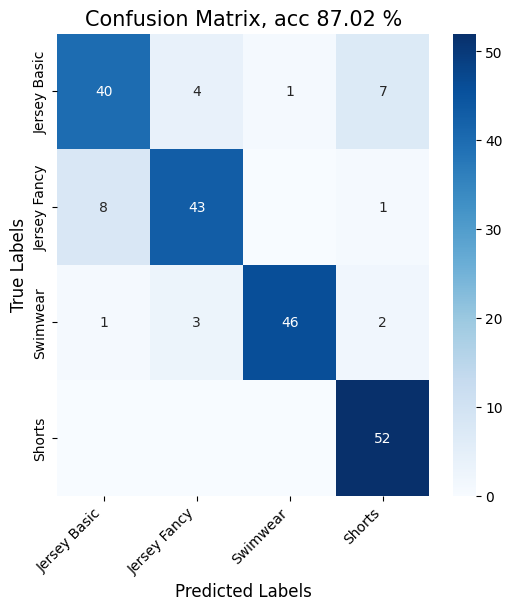

Accuracy of soft prompt is 87.02 %


In [72]:
ft.plot_loss()
#utils.print_images(dataloader_train, processor,3)
all_predictions, all_labels, acc = ft.eval(False)
utils.confussion_matrix(all_labels, all_predictions, list(dataloaders['test'].dataset.class_to_id.keys()),F1=False)
print(f"Accuracy of soft prompt is {acc:.2f} %")

## LoRA

**Hyperparam search for LoRA**

---


In [ ]:

dataloaders = {'train':dataloaders_tr_va_te['train'], 
               'val':dataloaders_tr_va_te['val'],
               'test':dataloaders_tr_va_te['val']}# for hyperparameter val performance
# Hyperparameter space
learning_rates = [1e-5, 5e-5, 1e-4]
initial_ranks = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256]
weight_decays = [0.0, 0.01, 0.1 , 0.0001]

results = []

for lr, wd in itertools.product(learning_rates, weight_decays):
    ranks = initial_ranks.copy()
    start = len(ranks) - 3

    for i in range(start, len(ranks) - 1):
        ranks[i] = 0

        if all(rank == 0 for rank in ranks):
            print("All ranks are set to 0. Exiting the loop.")
            break
            
        clip = {'m': copy.deepcopy(model), 'p': processor} # deepcopy does not change in model

        lora_layers = []
        lora_layers = model_functions.apply_lora_to_transformer(clip['m'].text_model.encoder.layers, lora_layers, ranks)
        lora_params_attention = model_functions.get_lora_params(clip['m'], print_layer=False)
        
        ft = training.FinetuneCLIP(dataloaders, clip, epochs = 250)

        ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc'] = 0, 1, 1  # Enable LoRA and Image FC
        ft.initialize({'LoRA': lora_params_attention, 'lr': lr, 'weight_decay': wd})
        ft.count_parameters()
        ft.train()

        all_predictions, all_labels, acc = ft.eval(False)
        #utils.confussion_matrix(all_labels, all_predictions, list(dataloaders['test'].dataset.class_to_id.keys()), F1=False)
        print(f"Accuracy for rank configuration {ranks} with lr={lr}, wd={wd} is {acc:.2f} %")
        results.append({'ranks': ranks.copy(), 'accuracy': acc, 'lr': lr, 'wd': wd})
for result in results:
    print(f"Rank configuration: {result['ranks']}, Learning Rate: {result['lr']}, Weight Decay: {result['wd']}, Accuracy: {result['accuracy']:.2f} %")

**LoRA Train with specifc Parameters**

---


text_model.encoder.layers.11.self_attn.k_proj.lora_A
text_model.encoder.layers.11.self_attn.k_proj.lora_B
text_model.encoder.layers.11.self_attn.v_proj.lora_A
text_model.encoder.layers.11.self_attn.v_proj.lora_B
text_model.encoder.layers.11.self_attn.q_proj.lora_A
text_model.encoder.layers.11.self_attn.q_proj.lora_B
text_model.encoder.layers.11.self_attn.out_proj.lora_A
text_model.encoder.layers.11.self_attn.out_proj.lora_B
Total number of parameters in the optimizer: 1313792


100%|██████████| 2/2 [00:00<00:00, 47.74it/s]


Accuracy 89.42857360839844


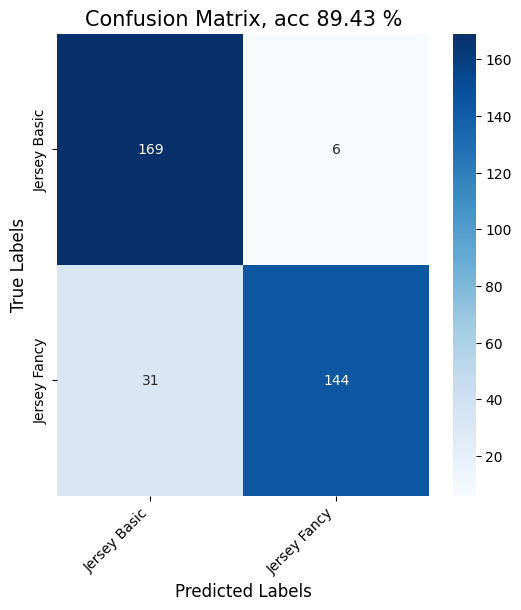

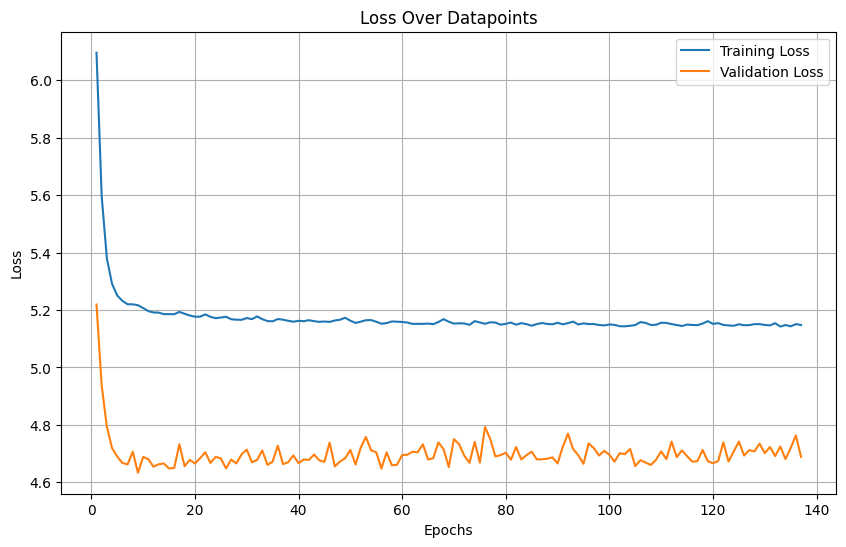

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=0.001, wd=0.001 is 89.43 %


In [63]:
ranks = [0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 256]  # Only apply LoRA with rank 64 to the last layer

#ranks = [256, 256, 256, 256, 256, 256, 256, 256,256, 256, 256, 256]  # Only apply LoRA with rank 64 to the last layer
lr = 1e-03
wd = 0.001
epochs_num = 500
lora_layers = []

clip = {'m': copy.deepcopy(model), 'p': processor} # do not load each time
lora_layers = model_functions.apply_lora_to_transformer(clip['m'].text_model.encoder.layers , lora_layers, ranks)
lora_params_attention = model_functions.get_lora_params(clip['m'], print_layer = True);

# Set up dataloaders and fine-tune process
dataloaders = {'train':dataloaders_tr_va_te['train'],
               'val':dataloaders_tr_va_te['val'], 
               'test':dataloaders_tr_va_te['test']}
ft = training.FinetuneCLIP(dataloaders, clip, epochs = epochs_num )

# Initialize LoRA training with current hyperparameters
ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc'] = 0, 1 ,0 # Enable LoRA
ft.initialize({'LoRA': lora_params_attention, 'lr': lr, 'weight_decay': wd, 'num_soft':num_soft, 'add':''})

ft.count_parameters()

# Set the optimizer parameters for learning rate and weight decay
#ft.optimizer_params = {'lr': lr, 'weight_decay': wd}  # Ensure your FinetuneCLIP handles this

# Train the model
ft.es['pat']=30
ft.train()

# Evaluate the model
all_predictions, all_labels, acc = ft.eval(False)
utils.confussion_matrix(all_labels, all_predictions, list(dataloaders['test'].dataset.class_to_id.keys()), F1=False)
ft.plot_loss()

print(f"Accuracy for rank configuration {ranks} with lr={lr}, wd={wd} is {acc:.2f} %")

**Train SoftPrompt with Tuned LoRA/CLIP Model**

---


100%|██████████| 1/1 [00:00<00:00, 43.53it/s]


Accuracy 97.0


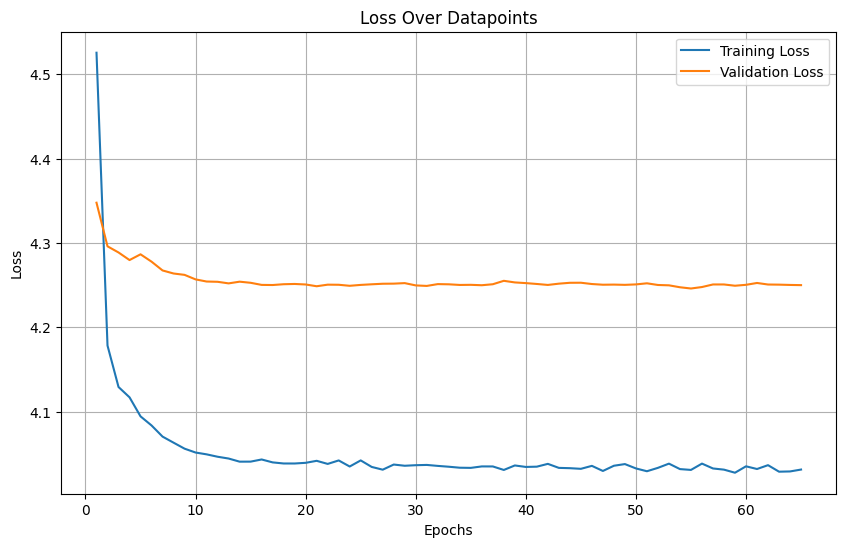

Accuracy  97.00 %


In [93]:
dataloaders = {'train':dataloaders_tr_va_te['train'], 'val':dataloaders_tr_va_te['val'], 'test':dataloaders_tr_va_te['test']}
num_soft = 5
ft = training.FinetuneCLIP(dataloaders, clip)# tuned model in clip passed from past section
ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc'] = 1, 0 , 0 #soft
ft.initialize({'num_soft':num_soft, 'add':''})
ft.train()
# Evaluate the model
all_predictions, all_labels, acc = ft.eval(False)
#utils.confussion_matrix(all_labels, all_predictions, list(dataset_test.class_to_id.keys()), F1=False)
ft.plot_loss()
print(f"Accuracy  {acc:.2f} %")


## Dag anything

In [ ]:
dataloaders = {'train':dataloaders_tr_va_te['train'], 'val':dataloaders_tr_va_te['val'], 'test':dataloaders_tr_va_te['test']}
clip = {'m':model, 'p':processor}

ft = training.FinetuneCLIP(dataloaders, clip)

In [33]:
update()# run if you have changed any file

## Evaluate on all

In [17]:
def evaluate_on_all():#TODO baseline on all columns, imbalance outliers with 1
    n_samples = 50
    batch_size = 2**8
    subclasses = []
    accs = []
    #'prod_name' has only one in some
    # 'product_type_name' has some with only one 
    # 'product_group_name' has some with one
    # 'graphical_appearance_name' has 7
    # 'colour_group_name' about 20%
    main_classes = ['colour_group_name', 'perceived_colour_value_name',
        'perceived_colour_master_id', 'perceived_colour_master_name',
        'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']
    
    main_classes = ['garment_group_name']
    for main_class in tqdm(main_classes):
        _ = datasets.create_dataset(n_samples, main_class, subclasses, 
                   {'m':model, 'p':processor}, {'hm':HM_DATA_PATH, 'save':PTH_SAVE_PATH}, device, False, include, show=False)
        
        data = datasets.load_dataset(n_samples, main_class, len(subclasses),
                             {'hm':HM_DATA_PATH, 'save':PTH_SAVE_PATH})

        dataloaders_tr_va_te = datasets.generate_train_test_val(data['class_text'], 
                            data['image_embedding'], data['images'],batch_size, n_samples, SET_SIZES, show=False)
        
        dataloaders = {'train':dataloaders_tr_va_te['train'],
            'val':dataloaders_tr_va_te['val'],
            'test':dataloaders_tr_va_te['test']}
        
        clip = {'m':model, 'p':processor}
        ft = training.FinetuneCLIP(dataloaders, clip)
        ft.tt['soft'], ft.tt['LoRA'] = 0, 0 #baseline
        ft.initialize({'add':''})
        all_predictions, all_labels, acc = ft.eval(False)
        accs.append(acc)
evaluate_on_all()

  0%|          | 0/1 [00:00<?, ?it/s]

Max uniform size: 908


/opt/conda/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(

100%|██████████| 1/1 [00:18<00:00, 18.54s/it]

Accuracy 35.238094329833984


## Train on 1 evaluate on another

In [45]:
def train_1_eval_2(main_class_1, main_class_2,params, settings, clip):
    """Trains on first and evaluates on second"""
    n_samples = 50
    batch_size = 2**8
    subclasses = []
    
    datasets.create_dataset(n_samples, main_class_1, subclasses, 
                   {'m':model, 'p':processor}, {'hm':HM_DATA_PATH, 'save':PTH_SAVE_PATH}, device, False, include, show=False)
    datasets.create_dataset(n_samples, main_class_2, subclasses, 
                   {'m':model, 'p':processor}, {'hm':HM_DATA_PATH, 'save':PTH_SAVE_PATH}, device, False, include, show=False)
    
    data_1 = datasets.load_dataset(n_samples, main_class_1, len(subclasses),
                             {'hm':HM_DATA_PATH, 'save':PTH_SAVE_PATH})
    data_2 = datasets.load_dataset(n_samples, main_class_2, len(subclasses),
                             {'hm':HM_DATA_PATH, 'save':PTH_SAVE_PATH})
    
    
    dataloaders_tr_va_te_1 = datasets.generate_train_test_val(data_1['class_text'], 
                            data_1['image_embedding'], data_1['images'],batch_size, n_samples, SET_SIZES, show=False)
    dataloaders_tr_va_te_2 = datasets.generate_train_test_val(data_2['class_text'], 
                            data_2['image_embedding'], data_2['images'],batch_size, n_samples, SET_SIZES, show=False)
    
    dataloaders = {'train':dataloaders_tr_va_te_1['train'],
            'val':dataloaders_tr_va_te_1['val'],
            'test':dataloaders_tr_va_te_1['test']}
    
    
    
    clip0 = {'m': copy.deepcopy(model), 'p': processor} 
    ft = training.FinetuneCLIP(dataloaders, clip0, 300)
    ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc']  = 0, 0,0 #baseline
    ft.initialize({'add':''})
    
    _, _, acc_1base = ft.eval(False)# 1 base
    
    
    ft.dataloaders['test'] = dataloaders_tr_va_te_2['test']
    _, _, acc_2base = ft.eval(False) # 2 base
    
    ft = training.FinetuneCLIP(dataloaders, clip, 300)
    ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc']  = settings
    ft.initialize(params)
    
    _, train_p = ft.train()
    
    _, _, acc_21 = ft.eval(False) # 2 trained on 1
    
    ft.dataloaders['test'] = dataloaders_tr_va_te_1['test']
    _, _, acc_11 = ft.eval(False) # 1 trained on 1
    
    return [acc_1base, acc_11, acc_2base, acc_21]

**For Soft prompts**

In [48]:
clip = {'m': copy.deepcopy(model), 'p': processor} 
acc = train_1_eval_2('garment_group_name', 'index_group_name',
                       {'num_soft':5}, (1,0,0), clip)
print(acc)

Max uniform size: 908


/opt/conda/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Max uniform size: 3392


/opt/conda/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 46.32it/s]


Accuracy 35.238094329833984


100%|██████████| 1/1 [00:00<00:00, 95.18it/s]


Accuracy 28.0


100%|██████████| 1/1 [00:00<00:00, 87.04it/s]


Accuracy 20.0


100%|██████████| 1/1 [00:00<00:00, 57.41it/s]

Accuracy 60.9523811340332
[35.238094329833984, 60.9523811340332, 28.0, 20.0]


**For LoRA**

In [49]:
ranks = [0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 256] 
lr = 1e-04
wd = 0.0001
lora_layers = []

clip = {'m': copy.deepcopy(model), 'p': processor} # do not load each time
lora_layers = model_functions.apply_lora_to_transformer(clip['m'].text_model.encoder.layers , lora_layers, ranks)
lora_params_attention = model_functions.get_lora_params(clip['m'], print_layer = True);
acc = train_1_eval_2('garment_group_name', 'index_group_name',
                       {'LoRA': lora_params_attention, 'lr': lr, 'weight_decay': wd}, (0,1,0), clip)
print(acc)

text_model.encoder.layers.11.self_attn.k_proj.lora_A
text_model.encoder.layers.11.self_attn.k_proj.lora_B
text_model.encoder.layers.11.self_attn.v_proj.lora_A
text_model.encoder.layers.11.self_attn.v_proj.lora_B
text_model.encoder.layers.11.self_attn.q_proj.lora_A
text_model.encoder.layers.11.self_attn.q_proj.lora_B
text_model.encoder.layers.11.self_attn.out_proj.lora_A
text_model.encoder.layers.11.self_attn.out_proj.lora_B
Max uniform size: 908


/opt/conda/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Max uniform size: 3392


/opt/conda/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 58.35it/s]


Accuracy 35.238094329833984


100%|██████████| 1/1 [00:00<00:00, 77.91it/s]


Accuracy 28.0


100%|██████████| 1/1 [00:00<00:00, 79.37it/s]


Accuracy 36.0


100%|██████████| 1/1 [00:00<00:00, 52.07it/s]

Accuracy 63.80952453613281
[35.238094329833984, 63.80952453613281, 28.0, 36.0]
